# Demonstration of LTER and IOOS Combining
This notebook demonstrates the basic capabilities of a number of functions/libraries that can be used to pull LTER and IOOS datasets. The basic functionality is demonstrated and explained below.

## Preamble
A few initial set-up libraries to install.

In [1]:
%matplotlib inline

import sys
sys.path.append("../ohw_lter_vis") # go to parent dir
from load_Seward_CTD import make_CTD_dataframe
from load_Seward_zooplankton import make_zooplankton_dataframe
from ioos_lib import *
import ohw_lter_vis as olv

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


## Pulling in LTER
First, let's pull in some CTD data from LTER. For this demonstration, we're pulling in data from the Northern Gulf of Alaska. Data were collected by investigators and submitted to the archive in a variety of formats, so we wrote individual functions to read in each type from a hardcoded URL.

The zooplankton data are from the file Seward_ZooData_Calvet_2012-2016_final.csv available via AOOS's Gulf of Alaska Data Portal. The CTD are from Spring 2012

In [2]:
CTD_df = make_CTD_dataframe()
print('{}-{}'.format(CTD_df.time.min(),CTD_df.time.max()))
CTD_df.head(5)

#read in the Zooplankton data and trim to 2012.
zoo_df = make_zooplankton_dataframe(year=2012)
zoo_df = zoo_df[zoo_df.time<pd.Timestamp('2012-05-10')]
zoo_df = zoo_df[zoo_df.time>pd.Timestamp('2012-05-04')]



2012-05-04 05:21:55-2012-05-09 22:16:58


Now, let's contextualize this with a map of Sea Surface Temperature.

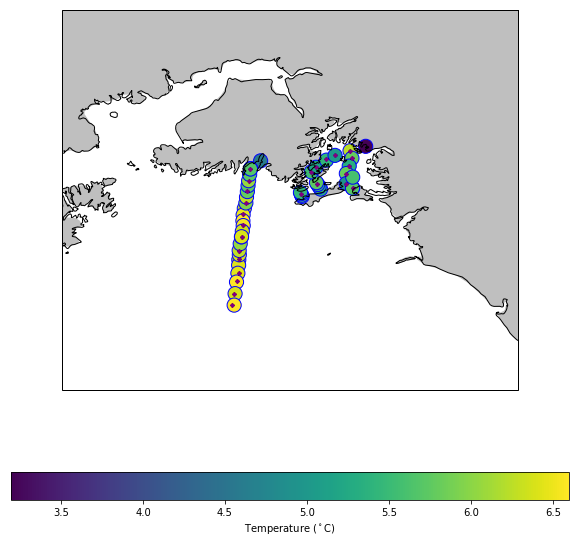

In [3]:
# Pull out the values at the surface
surface = CTD_df[CTD_df['pressure']==0]

# make a map of dots shaded by SST
[fig,ax] = olv.map_ngalter()
[h,ax] = olv.map_stations_data(ax ,surface, colorby='temperature', colormap='viridis')
plt.colorbar(h, orientation='horizontal', label='Temperature ($^\circ$C)')

# add zooplankton collection locations as purple dots
ax.scatter(zoo_df['longitude'], zoo_df['latitude'], transform=ccrs.Geodetic(), s=5, c='purple');


## Pulling in Model Output via the IOOS Data Catalog
Now, let's try to see what's going on in the oceanographic world. We'll pull in some model data from the same rough time range, and use it as an underlay on the plot.

First, we'll set up our initial filter for getting our data of interest. We'll do this with a spatial, topic, temporal, and datatype specification.

In [4]:
# Let's define our region of interest
roi = [-154, -142, 58.5, 61.]

# And let's say we would like to grab labels with salinity or temperature data in the filter
labels = fetch_labels('temperature')+fetch_labels('salinity')

# And here are our dates of interest -- these are the dates of the cruise above
start, stop = fetch_dates(2012, 5, 4, 5)

# Finally, we make our datascraper object, and make sure to specify we're interested in getting model data
ds = DataScraper(roi, start, stop, labels, models_only=True)

Now that our data-retreiving object is made, we can now query the IOOS database for the records of interest. This process involves querying for record urls, processing the metadata from those urls, and assembling an "access database" which we can use to eventually pull the data of interest.

In [5]:
ds.get_records()
ds.create_database()
ds.df.head(5)

Found 1 records.



,scheme,url,geolink
0,WWW:LINK,https://ecowatch.ncddc.noaa.gov/thredds/dodsC/...,WWW:LINK
1,WWW:LINK,http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta....,None
2,OPeNDAP:OPeNDAP,https://ecowatch.ncddc.noaa.gov/thredds/dodsC/...,None
3,OGC:WCS,https://ecowatch.ncddc.noaa.gov/thredds/wcs/nc...,OGC:WCS
4,OGC:WMS,https://ecowatch.ncddc.noaa.gov/thredds/wms/nc...,OGC:WMS


Since records exist for our initial criteria, we can now pull the data in.

Choose the <a href="https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/navoceano-ncom-glb">Naval Oceanographic Office Global Navy Coastal Ocean Model (NCOM)</a> available via a <a href="https://ecowatch.ncddc.noaa.gov">NOAA</a> THREDDS server.

In [6]:
ds.get_models()
mod = xr.open_dataset(ds.model_urls[0])
mod

{'https://ecowatch.ncddc.noaa.gov/thredds/dodsC/ncom/ncom_reg7_agg/NCOM_Region_7_Aggregation_best.ncd': <GridGeo: unknown_1d>}


<xarray.Dataset>
Dimensions:      (depth: 40, lat: 441, lon: 401, time: 8682)
Coordinates:
  * depth        (depth) float64 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat          (lat) float64 10.0 10.12 10.25 10.38 ... 64.62 64.75 64.88 65.0
  * lon          (lon) float64 -150.0 -149.9 -149.8 ... -100.2 -100.1 -100.0
  * time         (time) datetime64[ns] 2010-01-13 ... 2013-03-22
    time_run     (time) datetime64[ns] ...
Data variables:
    time_offset  (time) datetime64[ns] ...
    salinity     (time, depth, lat, lon) float32 ...
    surf_el      (time, lat, lon) float32 ...
    water_temp   (time, depth, lat, lon) float32 ...
    water_u      (time, depth, lat, lon) float32 ...
    water_v      (time, depth, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:  

Wonderful! So now, we can take this model and examine it for the parameters we care about. There are a few prototype tools that are provided to do this for us; but it does require that you know the parameter names that you are looking for. We invite you to examine the ```ioos_lib.py``` file in this respository for those helper functions.

In [7]:
# Let's pull temperature and salinity data for the first day of the cruise
tempy = ds.open_models(param_of_interest='water_temp', date_of_interest=start)
salty = ds.open_models(param_of_interest='salinity', date_of_interest=start)
tempy

[<xarray.DataArray 'water_temp' (time: 1, lat: 441, lon: 401)>
 [176841 values with dtype=float32]
 Coordinates:
     depth     float64 2.0
   * lat       (lat) float64 10.0 10.12 10.25 10.38 ... 64.62 64.75 64.88 65.0
   * lon       (lon) float64 -150.0 -149.9 -149.8 -149.6 ... -100.2 -100.1 -100.0
   * time      (time) datetime64[ns] 2012-05-04
     time_run  (time) datetime64[ns] ...
 Attributes:
     units:          degC
     long_name:      Water Temperature
     NAVO_code:      15
     standard_name:  sea_water_temperature]

Now, we have both the temperature and salinity models available to us. Let's plot them, just to get a sense of what we'll be looking at.

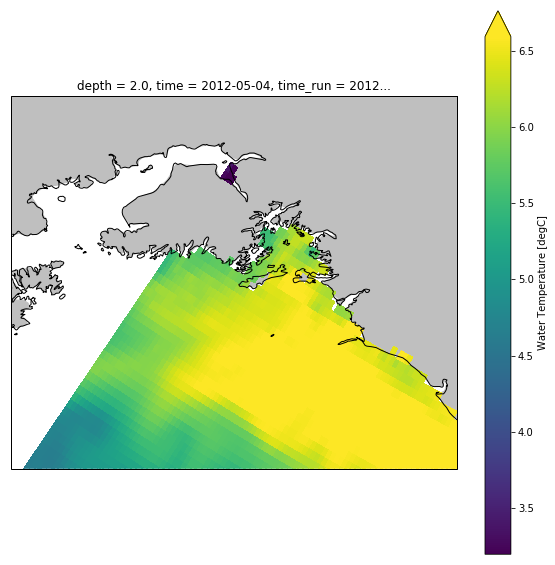

In [8]:
[fig,ax] = olv.map_ngalter()

# Add the temperature model
tempy[0].plot(x='lon', 
              y='lat',
              ax=ax,
              transform=ccrs.PlateCarree(),
              vmin=np.nanmin(surface['temperature']), 
              vmax=np.nanmax(surface['temperature']),
)


## Bringing it Together -- Comparing Model and Measure

Now, let's do a few simple tasks to actually combine our LTER measurements and our IOOS provided model. Perhaps we're interested in seeing how similar the actual measurements are to the model values.

We first compare these two datasets spatially.

Note: This section illustrates one of the dangers with using Python packages - between the time of OceanHackWeek and my presentation at CFOS, an update to matplotlib broke this section of code.  I fixed it by reverting to the older version of matplotlib using my conda environment.

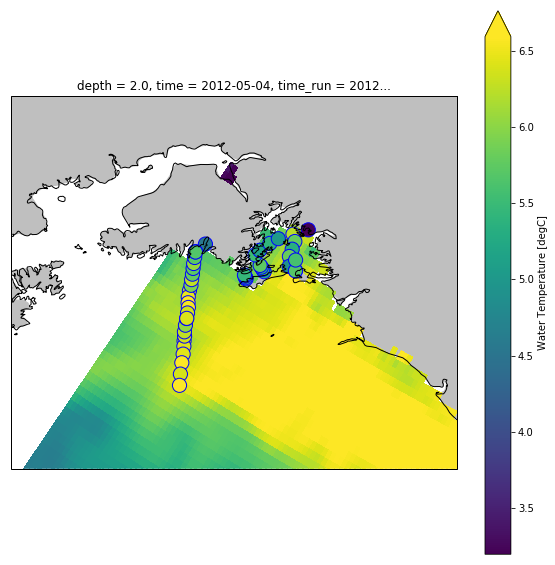

In [9]:
# Make the map object
[fig,ax] = olv.map_ngalter()

# Plot the temperature data, scaled to the measurements
tempy[0].plot(x='lon', y='lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=np.nanmin(surface['temperature']), 
    vmax=np.nanmax(surface['temperature']),
)

# Plot the measurements
[mapper,ax] = olv.map_stations_data(ax, surface, colorby='temperature', colormap='viridis')

# Note: on 10/3/2018, this code block gave the error:
# 'GeoAxesSubplot' object has no attribute '_hold'
# Googling that found this issue with cartopy:
# https://github.com/SciTools/cartopy/issues/1120
# which tracked the problem to matplotlib v3.0.0 released 16 days ago.
# Probably, we had matplotlib v2.3.3, so downgrade to that in conda env. And that worked.

## Interpolate Model to CTD Station Locations

Use an interpolation function wrapped by Xarray to interpolate the model output to 
the CTD station locations.

In [10]:
# Note: with scipy v1.1.0, there is a list of "FutureWarning" messages that originate
# with numpy. Issue tracker on scipy's GitHub says this will be fixed in scipy v1.2.0
# but as of 10/5/2018 that isn't released yet. Current version is 1.0.0.
# So filter out all those warnings.
import warnings
warnings.filterwarnings('ignore')

# Let's grab the model values for the coordinates of the actual stations
mtemp=[]
lat = surface['latitude'].values
lon = surface['longitude'].values
for olat,olon in zip(lat,lon):
    mtemp.append(tempy[0].interp(lon=olon,lat=olat,method='nearest', assume_sorted=False).values[0])
diff = surface['temperature'].values - mtemp



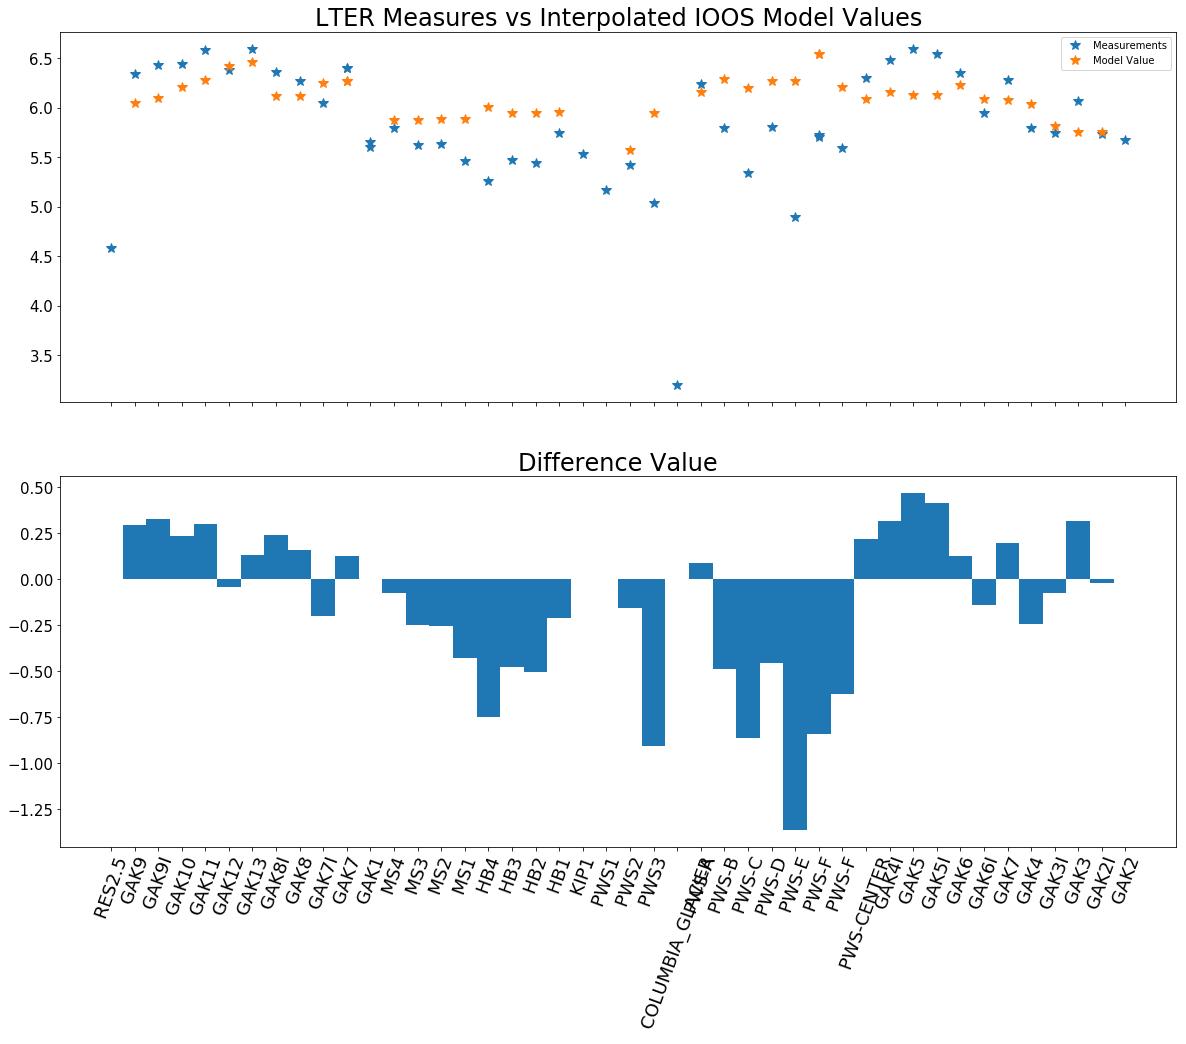

In [11]:
# And let's see what that looks like in "raw values" and as a difference plot
plt.rcParams['ytick.labelsize'] = 15 
plt.rcParams['xtick.labelsize'] = 15

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20,15))

ax1.plot(surface['station'],surface['temperature'].values, label='Measurements',marker='*', linestyle='', markersize=10)
ax1.plot(surface['station'],mtemp, label='Model Value',marker='*', linestyle='', markersize=10)
ax1.set_title('LTER Measures vs Interpolated IOOS Model Values', fontsize=24)
ax1.legend()

ax2.bar(surface['station'].values, diff, width=1,align='center')
ax2.set_title('Difference Value', fontsize=24)
ax2.set_xticklabels(surface['station'],rotation=70,fontsize=18)

plt.show()

## Where are the biggest differences?

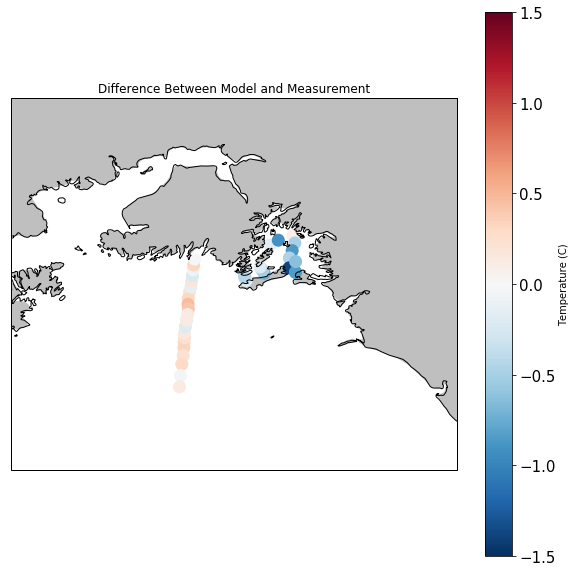

In [12]:
# Make the map object
[fig,ax] = olv.map_ngalter()
ax.set_extent((ds.min_lon, ds.max_lon, ds.min_lat, ds.max_lat))

mapper = ax.scatter(lon, lat, c=diff, cmap='RdBu_r',transform=ccrs.Geodetic(),vmin=-1.5, vmax=1.5, s=100, linewidth=3)
mapper.vmin = -10
plt.colorbar(mapper, label='Temperature (C)')
plt.title('Difference Between Model and Measurement')
plt.show()

The model is too warm in Prince William Sound, but fits pretty well in the Gulf of Alaska

# Join Zooplankton Data to CTD Data

Now join the CTD summary stats to zooplankton samples. There are no common 
identifiers (keys) that match exactly between zooplankton and CTD dataframes, 
so Rachel ran a "nearest neighbor" join based on the time parameter. Python requires a 
sort on date-time first.


In [13]:
# Join Zooplankton to CTD using time as the shared value
# Since calvets are vertically integrated measurement, average T and S
zoo_sorted = zoo_df.sort_values(by=['time'])
ctd_sorted = CTD_df.sort_values(by=['time'])
ctd_grouped = CTD_df.groupby(["time"]).agg({"salinity":"mean", "temperature":"mean"})
ctd_grouped = ctd_grouped.reset_index()

joined_ctd_zoo = pd.merge_asof(zoo_sorted, ctd_grouped, on='time', direction="nearest")

# The aggregate the zooplankton data
zoo_class_df = joined_ctd_zoo.groupby(["Class","temperature","salinity"]).agg({"Abundance (no m-3)":"mean"})
zoo_class_df = zoo_class_df.reset_index()
zoo_class_df = zoo_class_df.rename(columns={'Abundance (no m-3)':'Abundance'})
print(zoo_class_df.loc[zoo_class_df['Class'] == 'Actinopterygii'])

# Sum the abundances over all the stations
zoo_class_df.groupby('Class').agg({"Abundance":"sum"})

             Class  temperature   salinity  Abundance
0   Actinopterygii     3.853209  34.017629   0.153488
1   Actinopterygii     4.013828  31.495712   0.753082
2   Actinopterygii     4.128843  33.882555   0.396287
3   Actinopterygii     4.430698  32.156949   0.836286
4   Actinopterygii     4.718456  31.730632   0.235632
5   Actinopterygii     4.816737  32.013143   0.336144
6   Actinopterygii     4.982944  31.866135   1.014636
7   Actinopterygii     5.044169  31.612803   1.137236
8   Actinopterygii     5.133478  32.244761   0.129056
9   Actinopterygii     5.199437  31.795539   0.760116
10  Actinopterygii     5.289227  32.351206   0.209962
11  Actinopterygii     5.349418  32.357264   0.356982
12  Actinopterygii     5.504423  32.871290   0.435942


,Abundance
Class,
Actinopterygii,6.754849
Appendicularia,1276.222727
Ascideacea,17.242424
Bivalvia,26.055840
Cephalopoda,0.396287
Gastropoda,260.240584
Hydrozoa,28.941864
Malacostraca,1126.654499
Maxillopoda,1661.394600


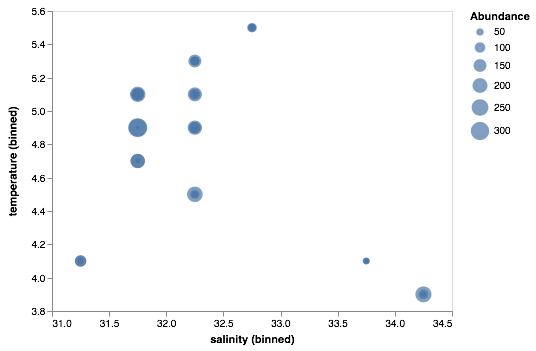

In [14]:
import altair as alt
alt.renderers.enable("notebook")

alt.Chart(zoo_class_df).mark_circle().encode(
    alt.X('salinity:Q', bin=True),
    alt.Y('temperature:Q', bin=True),
    size='Abundance:Q'
)